In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np 
import torchvision.transforms as transforms
import copy
import librosa
import soundfile as sf
import librosa.display
from tqdm import tqdm

In [ ]:
#클래스 선언
class CNNModel(nn.Module):
	def __init__(self):
		super(CNNModel, self).__init__()
		self.cnn1 = nn.Sequential(
				nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
			 	nn.ReLU())
		self.cnn2 = nn.Sequential(
				nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1, padding=1),
			 	nn.ReLU()
		)
	def forward(self, x):
		out = self.cnn1(x)
		return out

class GramMatrix(nn.Module):
	def forward(self, input):
		a, b, c = input.size()
		features = input.view(a * b, c) 
		G = torch.mm(features, features.t())
		return G.div(a * b * c)
#좀 변경됨
class StyleLoss(nn.Module):
	def __init__(self, target, weight):
		super(StyleLoss, self).__init__()
		self.target = target.detach() * weight
		self.weight = weight
		self.gram = GramMatrix()
		self.criterion = nn.MSELoss()

	def forward(self, input):
		self.output = input.clone()
		self.G = self.gram(input)
		self.G.mul_(self.weight)
		self.loss = self.criterion(self.G, self.target)
		return self.output

	def backward(self,retain_graph=True):
		self.loss.backward(retain_graph=retain_graph)
		return self.loss
class ContentLoss(nn.Module):
	def __init__(self, target):
			super(ContentLoss, self).__init__()
			self.target = target.detach()

	def forward(self, input):
			self.loss = F.mse_loss(input, self.target)
			return self.loss

# function

In [ ]:
#variable
N_FFT=2048
style_weight=1025
content_weight = 1025
style_layers_default = ['conv_1']
content_layers_default = ['conv_1']
learning_rate_initial = 0.03
num_steps= 2500

In [ ]:
import torchaudio.transforms as T

def read_audio_spectum(filename, off):
	x, fs = librosa.load(filename, duration=47.54, offset = off)
	S = librosa.stft(x, N_FFT)
	p = np.angle(S)
	S = np.log1p(np.abs(S))  
	return S, fs

def get_style_model_and_losses(cnn, style_float,content_float,style_weight=style_weight,content_weight = content_weight, style_layers=style_layers_default, content_layers = content_layers_default): 
	cnn = copy.deepcopy(cnn)
	style_losses = []
	content_losses = []

	model = nn.Sequential()  
	gram = GramMatrix() 
	if torch.cuda.is_available():
		model = model.cuda()
		gram = gram.cuda()
	
	# i = 0  # increment every time we see a conv
	# for layer in cnn.children():
		
	# 	i += 1
	# 	name = 'conv_{}'.format(i)
	# 	print(i)
	# 	print("content_float :",content_float.shape)
	# 	print("style_float : ", style_float.shape)
	# 	if name in content_layers:
	# 		target_feature = model(content_float).clone()
	# 		content_loss = ContentLoss(target_feature)
	# 		model.add_module("content_loss_{}".format(i), content_loss)
	# 		content_losses.append(content_loss)
	# 	if name in style_layers:
	# 		target_feature = model(style_float).clone()
	# 		target_feature_gram = gram(target_feature)
	# 		style_loss = StyleLoss(target_feature_gram, style_weight)
	# 		model.add_module("style_loss_{}".format(i), style_loss)
	# 		style_losses.append(style_loss)		
	# 	model = model[:(i + 1)]

		# return model, style_losses, content_losses
	name = "conv_1"
	model.add_module(name, cnn.cnn1)
 
	if name in style_layers:
		target_feature = model(style_float).clone()
		target_feature_gram = gram(target_feature)
		style_loss = StyleLoss(target_feature_gram, style_weight)
		model.add_module("style_loss_1", style_loss)
		style_losses.append(style_loss)
		
	return model, style_losses


def get_input_param_optimizer(input_float):
	input_param = nn.Parameter(input_float.data)
	optimizer = optim.Adam([input_param], lr=learning_rate_initial, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
	return input_param, optimizer, input_float

def run_style_transfer(cnn, style_float, input_float, num_steps=num_steps, style_weight=style_weight, content_weight = content_weight): #STYLE WEIGHT, NUM_STEPS
	print('Building the style transfer model..')
	model, style_losses= get_style_model_and_losses(cnn, style_float,input_float, style_weight, content_weight)
	# model, style_losses, content_losses= get_style_model_and_losses(cnn, style_float,input_float,style_weight, content_weight)
	input_param, optimizer ,return_float= get_input_param_optimizer(input_float)
	print('Optimizing..')
 #====================================
	run = [0]
	plt.figure(figsize = (15,5))
	input_float.requires_grad_(False)
	while run[0] <= num_steps:
		def closure():
			input_param.data.clamp_(0, 1)
			optimizer.zero_grad()
			model(input_param)
			style_score = 0
			content_score = 0

			for sl in style_losses:
				style_score += sl.backward()
		
			content_loss = F.mse_loss(input_param, input_float)
			content_loss.backward()
			# for cs in content_losses:
				# content_score += cs();

			run[0] += 1
			if run[0] % 100 == 0:
				print("run {}:".format(run))
				print('Style Loss : {:8f}'.format(style_score.data)) #CHANGE 4->8 
				# print('Content Loss : {:.8f}'.format(content_score))
				print()
			if run[0] <100 and run[0] % 20 == 0:
				input_np = input_param.data.detach().cpu().numpy()
				input_np = np.squeeze(input_np, axis = 0)
				plt.subplot(1,5,run[0] / 20 + 1)
				plt.imshow(input_np)
				librosa.display.waveplot(input_np)
				

			return style_score
		optimizer.step(closure)
	 
	input_param.data.clamp_(0, 1)
	return input_param.data

#main

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Sampling Rates are same
Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.000001

run [200]:
Style Loss : 0.000001

run [300]:
Style Loss : 0.000001

run [400]:
Style Loss : 0.000001

run [500]:
Style Loss : 0.000001

run [600]:
Style Loss : 0.000001

run [700]:
Style Loss : 0.000001

run [800]:
Style Loss : 0.000001

run [900]:
Style Loss : 0.000001

run [1000]:
Style Loss : 0.000001

run [1100]:
Style Loss : 0.000001

run [1200]:
Style Loss : 0.000001

run [1300]:
Style Loss : 0.000001

run [1400]:
Style Loss : 0.000001

run [1500]:
Style Loss : 0.000001

run [1600]:
Style Loss : 0.000001

run [1700]:
Style Loss : 0.000001

run [1800]:
Style Loss : 0.000001

run [1900]:
Style Loss : 0.000001

run [2000]:
Style Loss : 0.000001

run [2100]:
Style Loss : 0.000001

run [2200]:
Style Loss : 0.000001

run [2300]:
Style Loss : 0.000001

run [2400]:
Style Loss : 0.000001

run [2500]:
Style Loss : 0.000001



100%|██████████| 500/500 [02:45<00:00,  3.01it/s]


DONE...


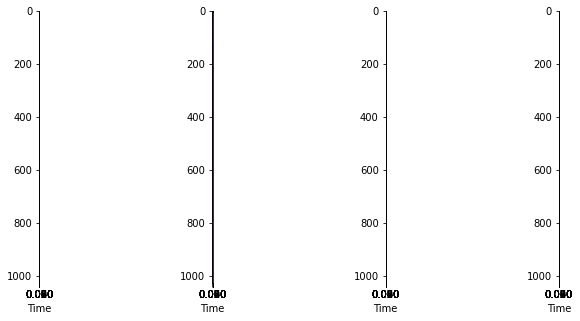

In [ ]:
if __name__ == '__main__':
	style_audio, style_sr = read_audio_spectum('./la_campanella_violin.mp3',15)
	content_audio, content_sr = read_audio_spectum('./la_campanella_piano.mp3',16)
	if(content_sr == style_sr):
		print('Sampling Rates are same')
	else:
		print('Sampling rates are not same')
		exit()
	style_audio = style_audio.reshape([1,1025,-1])
	content_audio = content_audio.reshape([1,1025,-1])


	if torch.cuda.is_available():
		style_float = Variable((torch.from_numpy(style_audio)).cuda())
		content_float = Variable((torch.from_numpy(content_audio)).cuda())	
	else:
		style_float = Variable(torch.from_numpy(style_audio))
		content_float = Variable(torch.from_numpy(content_audio))
	input_float = content_float.clone()
	
	cnn = CNNModel()
	if torch.cuda.is_available():
		cnn = cnn.cuda()

	output = run_style_transfer(cnn, style_float, input_float)
	if torch.cuda.is_available():
		output = output.cpu()
	output = output.squeeze(0)
	output = output.numpy()
	
	a = np.zeros_like(output)
	a = np.exp(output) - 1

	p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
	

	for i in tqdm(range(500)):
		S = a * np.exp(1j*p)
		x = librosa.istft(S)
		p = np.angle(librosa.stft(x, N_FFT))

	OUTPUT_FILENAME = 'output.wav'
	sf.write(OUTPUT_FILENAME, x, style_sr)

	print('DONE...')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


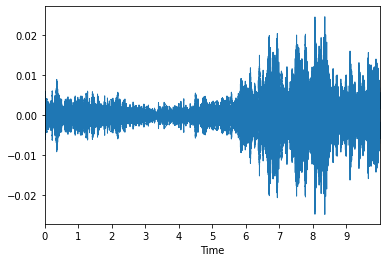

In [ ]:
style_au, st_sr = librosa.load('la_campanella_piano.mp3',duration = 10, offset = 16)
librosa.display.waveplot(style_au)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


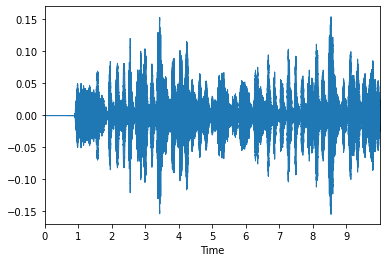

In [ ]:
content_au, ct_sr = librosa.load('la_campanella_violin.mp3', duration = 10, offset = 15)
librosa.display.waveplot(content_au)

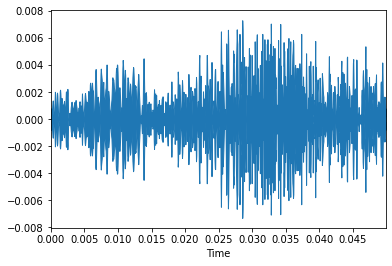

In [ ]:
import librosa.display
out, out_sr = librosa.load('output.wav',duration = 0.05)
librosa.display.waveplot(out)

In [ ]:
import IPython.display as ipd

In [ ]:
output_ad, output_sr = librosa.load("output.wav")
ipd.Audio(output_ad, rate = output_sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=220
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=221
  n_fft, y.shape[-1]


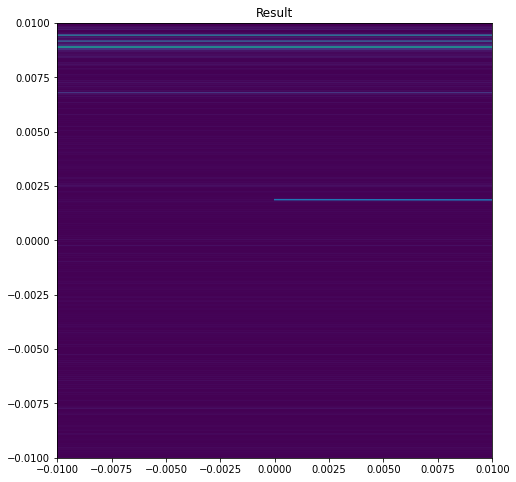

In [ ]:
#오디오 데이터 시각화
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

N_FFT=2048

def read_audio_spectum(filename):
	x, fs = librosa.load(filename, duration=0.01) # Duration=58.05 so as to make sizes convenient
	S = librosa.stft(x, N_FFT)
	p = np.angle(S)
	S = np.log1p(np.abs(S))  
	return S, fs

output_audio, output_sr = read_audio_spectum('output.wav')


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


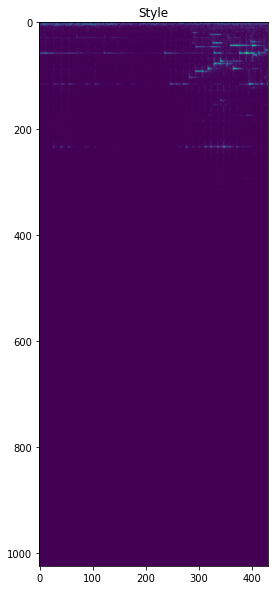

In [ ]:
input_audio, input_sr = read_audio_spectum('./la_campanella_piano.mp3',15)
content_audio, content_sr = read_audio_spectum('./la_campanella_violin.mp3',5)
output_aud, outp_sr  = read_audio_spectum('./output.wav',0)
plt.figure(figsize = (10,10))
plt.title('Style')
plt.imshow(input_audio[:,:])

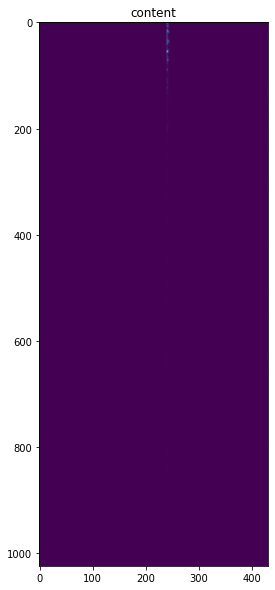

In [ ]:
plt.figure(figsize = (10,10))
plt.title('content')
plt.imshow(content_audio[:,:])

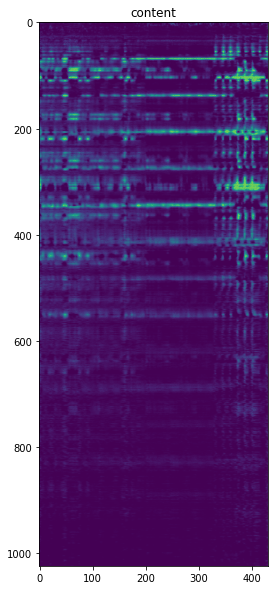

In [ ]:
plt.figure(figsize = (10,10))
plt.title('content')
plt.imshow(output_aud[:,:])